## Сравнение групп

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

In [2]:
df_train = pd.read_csv('data/minethatdata_womens_train.csv')

In [3]:
df_train.head()

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0
1,30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,Womens E-Mail,0,0,0.0
2,2725,8,1) $0 - $100,35.57,1,0,Surburban,0,Phone,No E-Mail,0,0,0.0
3,52884,1,1) $0 - $100,75.64,1,0,Surburban,1,Web,No E-Mail,0,0,0.0
4,42004,4,1) $0 - $100,29.99,1,0,Surburban,1,Web,Womens E-Mail,0,0,0.0


In [4]:
df_train['segment'].value_counts()

Womens E-Mail    10709
No E-Mail        10637
Name: segment, dtype: int64

In [5]:
# Разбиваю на целевую и контрольную группу
df_target = df_train[df_train['segment'] == 'Womens E-Mail']
df_control = df_train[df_train['segment'] == 'No E-Mail']

In [16]:
def compare_metrics(df_target, df_control):
    """
    Расчет метрик
    """
    visit_mean_control = df_control['visit'].mean()
    visit_mean_treated = df_target['visit'].mean()
    conversion_mean_control = df_control['conversion'].mean()
    conversion_mean_treated = df_target['conversion'].mean()
    spend_mean_control = df_control['spend'].mean()
    spend_mean_treated = df_target['spend'].mean()
    
    df_res = pd.DataFrame(data = {'mean_control': [visit_mean_control, conversion_mean_control, spend_mean_control],
                     'mean_treated': [visit_mean_treated, conversion_mean_treated, spend_mean_treated]},
                     index = ['visit', 'conversion', 'spend'],
                     columns = ['mean_control', 'mean_treated'])
    df_res['ate'] = df_res['mean_treated'] - df_res['mean_control']
    df_res['relative_change'] = df_res['mean_treated'] / df_res['mean_control']
    df_res = df_res.reset_index()
    cols = list(df_res.columns)
    cols[0] = 'variable'
    df_res.columns = cols
    
    return df_res

In [17]:
# Метрики для оригинального базового датасета
metrics_base = compare_metrics(df_target, df_control)
# Сохранение ответа
metrics_base.to_csv('solution.csv', index=False)

metrics_base

,variable,mean_control,mean_treated,ate,relative_change
0,visit,0.101720,0.148193,0.046473,1.456867
1,conversion,0.004983,0.008498,0.003515,1.705437
2,spend,0.583971,1.131093,0.547121,1.936898


In [9]:
df_target

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
1,30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,Womens E-Mail,0,0,0.0
4,42004,4,1) $0 - $100,29.99,1,0,Surburban,1,Web,Womens E-Mail,0,0,0.0
5,24975,12,1) $0 - $100,29.99,0,1,Surburban,1,Phone,Womens E-Mail,0,0,0.0
6,53600,2,"6) $750 - $1,000",846.18,0,1,Urban,1,Phone,Womens E-Mail,0,0,0.0
9,50189,4,5) $500 - $750,514.30,0,1,Surburban,1,Phone,Womens E-Mail,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21338,35946,7,1) $0 - $100,29.99,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
21339,50958,9,3) $200 - $350,239.15,0,1,Surburban,0,Web,Womens E-Mail,0,0,0.0
21342,57462,1,1) $0 - $100,76.88,1,0,Rural,1,Web,Womens E-Mail,1,0,0.0
21344,55020,11,1) $0 - $100,68.53,0,1,Surburban,1,Web,Womens E-Mail,1,0,0.0


## Волатильность метрик

Теперь оценим, насколько посчитанные выше метрики (ATE, relative_change) "шумные".  
Это нужно, чтобы понять, для каких переменных имеет смысл строить uplift-модель.  
Если оценка прироста переменной "шумная", вряд ли для неё получится хорошая uplift-модель.

Для этого предлагается посчитать доверительные интервалы метрик (с уровнем доверия 0.9)
и посмотреть на их ширину.  
Интервалы можно построить, используя bootstrapping

In [11]:
# Цикл генерации выборок
ate_visit, ate_conversion, ate_spend = [], [], []
rc_visit, rc_conversion, rc_spend = [], [], []
N = 1000  # Кол-во итераций для бутстрапа
for i in tqdm(range(N)):
    idx_t = random.choices(df_target.index, k=len(df_target))
    df_target_bootstrap = df_target.loc[idx_t]
    idx_c = random.choices(df_control.index, k=len(df_control))
    df_control_bootstrap = df_control.loc[idx_c]
    metrics_bootstrap = compare_metrics(df_target_bootstrap, df_control_bootstrap)
    
    ate_visit.append(metrics_bootstrap.loc['visit', 'ate'])
    ate_conversion.append(metrics_bootstrap.loc['conversion', 'ate'])
    ate_spend.append(metrics_bootstrap.loc['spend', 'ate'])
    rc_visit.append(metrics_bootstrap.loc['visit', 'relative_change'])
    rc_conversion.append(metrics_bootstrap.loc['conversion', 'relative_change'])
    rc_spend.append(metrics_bootstrap.loc['spend', 'relative_change'])

100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 47.96it/s]


In [30]:
# Построение 90% доверительного интервала
ate_visit_low, ate_visit_high = np.quantile(ate_visit, [0.05, 0.95])
ate_conversion_low, ate_conversion_high = np.quantile(ate_conversion, [0.05, 0.95])
ate_spend_low, ate_spend_high = np.quantile(ate_spend, [0.05, 0.95])
rc_visit_low, rc_visit_high = np.quantile(rc_visit, [0.05, 0.95])
rc_conversion_low, rc_conversion_high = np.quantile(rc_conversion, [0.05, 0.95])
rc_spend_low, rc_spend_high = np.quantile(rc_spend, [0.05, 0.95])

df_res2 = pd.DataFrame(data={'ate_low_border': [ate_visit_low, ate_conversion_low, ate_spend_low],
                             'ate_high_border': [ate_visit_high, ate_conversion_high, ate_spend_high],
                            'ate_range': [ate_visit_high - ate_visit_low, ate_conversion_high - ate_conversion_low, ate_spend_high - ate_spend_low],
                             'relative_change_low_border': [rc_visit_low, rc_conversion_low, rc_spend_low],
                             'relative_change_high_border': [rc_visit_high, rc_conversion_high, rc_spend_high],
                            'relative_change_range': [rc_visit_high - rc_visit_low, rc_conversion_high - rc_conversion_low, rc_spend_high - rc_spend_low]},
                       index=['visit', 'conversion', 'spend'])
df_res2

,ate_low_border,ate_high_border,ate_range,relative_change_low_border,relative_change_high_border,relative_change_range
visit,0.039193,0.054062,0.014869,1.374741,1.550353,0.175612
conversion,0.001732,0.005292,0.003561,1.286327,2.245669,0.959342
spend,0.225919,0.871614,0.645695,1.309515,2.950609,1.641094


Вывод: Смотрим на последнюю колонку **"relative_change_range"**, т.к. это относительные метрики.  
Видно, что доверительный интервал visit около 17%, а остальных метрик - гораздо больше.  

## Прогнозирование uplift

Видим, что разброс относительного прироста метрик conversion и spend большой. Поэтому
шансы получить хорошую uplift-модель для этих метрик малы.

Построим uplift-модель для **visit**

In [18]:
# Подготовка данных
df_train['treatment'] = (df_train['segment'] == "Womens E-Mail").astype('int32')

In [19]:
df_train.head()

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
0,54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0,0
1,30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,Womens E-Mail,0,0,0.0,1
2,2725,8,1) $0 - $100,35.57,1,0,Surburban,0,Phone,No E-Mail,0,0,0.0,0
3,52884,1,1) $0 - $100,75.64,1,0,Surburban,1,Web,No E-Mail,0,0,0.0,0
4,42004,4,1) $0 - $100,29.99,1,0,Surburban,1,Web,Womens E-Mail,0,0,0.0,1


In [20]:
def transform_(data: pd.DataFrame) -> pd.DataFrame:
    zipcode_num_dict = {
        'Urban': 0,
        'Surburban': 1,
        'Rural': 2
    }
    data['zip_code_num'] = data['zip_code'].apply(lambda s: zipcode_num_dict[s])
    
    channel_num_dict = {
        'Web': 0,
        'Multichannel': 1,
        'Phone': 2
    }
    data['channel_num'] = data['channel'].apply(lambda s: channel_num_dict[s])
#     data['history_segment__label'] = data['history_segment'].apply(lambda s: s[0])
#     data = one_hot_encode(data, cols=['zip_code', 'channel', 'history_segment__label'])
    return data

In [21]:
df_train = transform_(df_train)

In [22]:
df_train.columns

Index(['index', 'recency', 'history_segment', 'history', 'mens', 'womens',
       'zip_code', 'newbie', 'channel', 'segment', 'visit', 'conversion',
       'spend', 'treatment', 'zip_code_num', 'channel_num'],
      dtype='object')

In [23]:
column_set_n1 = [
    'recency',
    'history',
    'mens',
    'womens',
    'zip_code_num',
    'channel_num'
]

### Построение модели на деревьях

In [24]:
from causalml.inference.tree import UpliftRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._tree.TreeBuilder size changed, may indicate binary incompatibility. Expected 72 from C header, got 80 from PyObject


In [25]:
upmodel_rf = UpliftRandomForestClassifier(
    control_name='control',
#     evaluationFunction='CTS',
    n_estimators=10,
    max_depth=4,
    min_samples_leaf=500  # Число должно быть достаточно большим, чтобы аплифту в листьях можно было доверять на предикте
)

In [26]:
upmodel_rf.fit(
    X=df_train.loc[:, column_set_n1].values,
    treatment=df_train.loc[:, 'treatment'].apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=df_train.loc[:, 'visit'].values
)

### Предикт на новых данных

In [27]:
df_test = pd.read_csv('data/minethatdata_womens_test_no_answers.csv')

# Подготовка данных
df_test['treatment'] = (df_test['segment'] == "Womens E-Mail").astype('int32')
df_test = transform_(df_test)

In [28]:
df_test.head()

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,treatment,zip_code_num,channel_num
0,61726,2,1) $0 - $100,74.04,0,1,Urban,0,Phone,No E-Mail,0,0,2
1,57540,3,4) $350 - $500,435.14,1,0,Urban,1,Multichannel,Womens E-Mail,1,0,1
2,58265,3,2) $100 - $200,112.96,0,1,Surburban,0,Web,Womens E-Mail,1,1,0
3,46218,8,1) $0 - $100,29.99,1,0,Urban,1,Phone,No E-Mail,0,0,2
4,60139,7,3) $200 - $350,219.81,1,0,Rural,0,Multichannel,No E-Mail,0,2,1


In [29]:
eval_data = df_test.loc[:, column_set_n1 + ['index']]
eval_data['score'] = upmodel_rf.predict(eval_data[column_set_n1].values)
eval_data = eval_data[['index', 'score']]

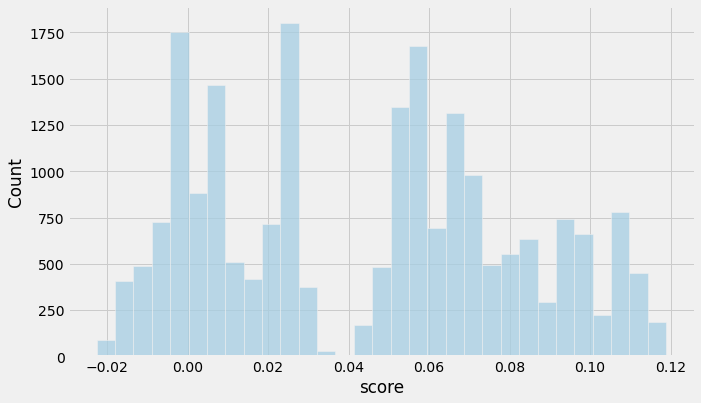

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(eval_data['score'])
plt.show()

In [31]:
eval_data

,index,score
0,61726,0.060799
1,57540,0.007814
2,58265,0.058684
3,46218,0.027434
4,60139,-0.003710
...,...,...
21342,61969,-0.001200
21343,26738,0.053993
21344,43585,-0.015290
21345,41551,-0.019753


In [57]:
# Сохранение ответа
eval_data.to_csv('solution2.csv', index=False)